# Classifying Blood cells using Convolutional Neural Network

by **Devnith Wijesinghe** <br>
created on **2nd August 2022**

## Overview

This dataset contains images of blood cells which we will use to train a CNN and classify which type they belong to. Here are the classes we are going to be classifying.

- basophil
- eosinophil
- erythroblast
- immunoglobulin
- lymphocyte
- monocyte
- neutrophil
- platelet

In this notebook we will explore how to load, preprocess, augment the data and train a model based on **accuracy** as performance metric.

## Importing modules and setting up

In [1]:
# Basic modules
import numpy as np 
import pandas as pd 
import os

# Tensorflow and OpenCV
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import cv2

# Plotting and graphing
import matplotlib.pyplot as plt
%matplotlib inline

# Tensorflow model building
from tensorflow import keras
from tensorflow.keras import layers

# Dataset manipulation
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

## Loading the dataset

Because the images are sorted into directories we can use the Tensorflow function **image_dataset_from_directory()**. We can also use the Tensorflow utility **ImageDataGenerator** to load the dataset while augmenting data in real-time. But since our dataset is large enough we will continute with the simple utility function.

In [2]:
# Parameters for the loader
batch_size = 16
img_height = 300
img_width = 300

data_directory = '../input/blood-cells-image-dataset/bloodcells_dataset'

In [3]:
# First load the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_directory,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 17092 files belonging to 8 classes.
Using 13674 files for training.


2022-08-02 17:43:05.013356: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-02 17:43:05.132173: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-02 17:43:05.133344: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-02 17:43:05.146369: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [4]:
# Next load the validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_directory,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 17092 files belonging to 8 classes.
Using 3418 files for validation.


The convenience of this function is that it automatically differentiates the train and validation data according to a split, and also imports class names. We can access them as below 

In [5]:
class_names = train_ds.class_names
print(class_names)

['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']


## Visualizing the data

We will now take a quick look at our dataset. By using **take()** on a dataset object we can peek at random 9 of our dataset images.

2022-08-02 17:43:11.137883: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


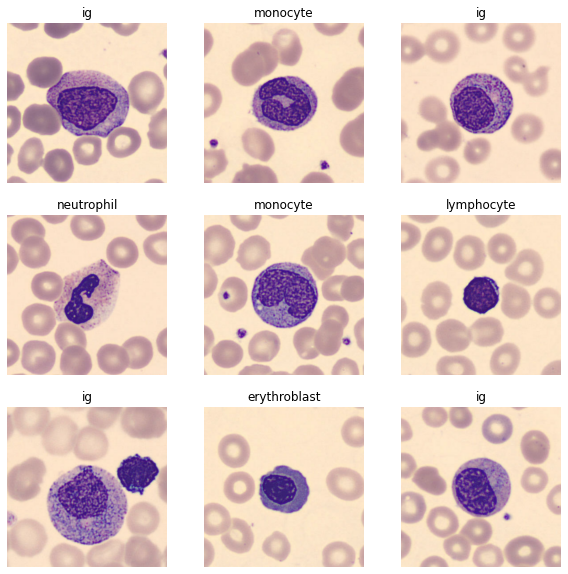

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Then we will also verify the shapes of our dataset components

In [7]:
# Tap into the shape of a single batch of data
for image_batch, label_batch in train_ds:
    print(image_batch.shape)
    print(label_batch.shape)
    break

(16, 300, 300, 3)
(16,)


The image_batch is a tensor of the shape **(16, 300, 300, 3)**. This is a batch of **16 images of shape 300x300x3** (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape **(16,)**, these are corresponding labels to the 16 images.
<br>
<br>
The values in the image tensors are ranging from 0 to 255. This is not good for training a neural network. Smaller values make algorithms like Gradient Descent to perform well. Therefore we must normalize our inputs to range between 0 and 1. We will do this through a layer in the neural network.([tf.keras.layers.Rescaling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Resizing))

## Model building

Our dataset looks clean and ready to go. Now we will build a quick model to fot the dataset and evaluate performance.


In [8]:
num_classes = len(class_names)

# Using sequential model
model = tf.keras.Sequential([
    keras.Input(shape=(300, 300, 3)),
    # Here is the rescaling layer which we use to normalize the input
    keras.layers.Rescaling(1./255),
    keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 300, 300, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 73, 73, 32)        0         
_________________________________________________________________
dense (Dense)                (None, 73, 73, 128)       4

In [9]:
# Compile the model
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

Now let's train the model using our **train_ds** as train data and **val_ds** as validation

In [10]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15
)

Epoch 1/15


2022-08-02 17:43:14.528734: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


855/855 [==============================] - 64s 65ms/step - loss: 1.0739 - accuracy: 0.6639 - val_loss: 0.5758 - val_accuracy: 0.7820
Epoch 2/15
855/855 [==============================] - 42s 49ms/step - loss: 0.4137 - accuracy: 0.8609 - val_loss: 0.4702 - val_accuracy: 0.8327
Epoch 3/15
855/855 [==============================] - 42s 49ms/step - loss: 0.2885 - accuracy: 0.9007 - val_loss: 0.3671 - val_accuracy: 0.8833
Epoch 4/15
855/855 [==============================] - 40s 47ms/step - loss: 0.2234 - accuracy: 0.9235 - val_loss: 0.3846 - val_accuracy: 0.8645
Epoch 5/15
855/855 [==============================] - 41s 47ms/step - loss: 0.1765 - accuracy: 0.9406 - val_loss: 0.3842 - val_accuracy: 0.8762
Epoch 6/15
855/855 [==============================] - 40s 47ms/step - loss: 0.1427 - accuracy: 0.9506 - val_loss: 0.4515 - val_accuracy: 0.8789
Epoch 7/15
855/855 [==============================] - 40s 47ms/step - loss: 0.1200 - accuracy: 0.9586 - val_loss: 0.5645 - val_accuracy: 0.8283
Epo

## Evaluating the model

Now let us look at the charts of our  train and validation accuracy and loss

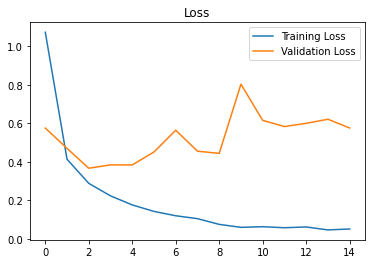

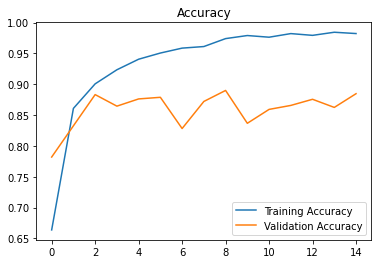

In [11]:
history = model.history.history

train_loss = history['loss']
val_loss = history['val_loss']
train_acc = history['accuracy']
val_acc = history['val_accuracy']

# Loss
plt.figure()
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Accuracy
plt.figure()
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

We can see from the graphs that there is a considerable gap between test and validation accuracies. To minimize this more layers of Dropout can be used to lower the variance. 

## Predictions

Let's look at some of the predicted images. 
<br>
But first we will run a quick evaluation on a single batch

In [12]:
# Grab a batch of data
for images, labels in val_ds.take(1):
    eval_images = images.numpy()
    eval_labels = labels.numpy()

# Evaluate model
score = model.evaluate(eval_images, eval_labels, verbose = 0) 

print('Validation Accuracy:', score[1])

Validation Accuracy: 0.875


This shows that 93% of this batch is predicted correctly. We will then plot the images while comparing their predicted and real classes.

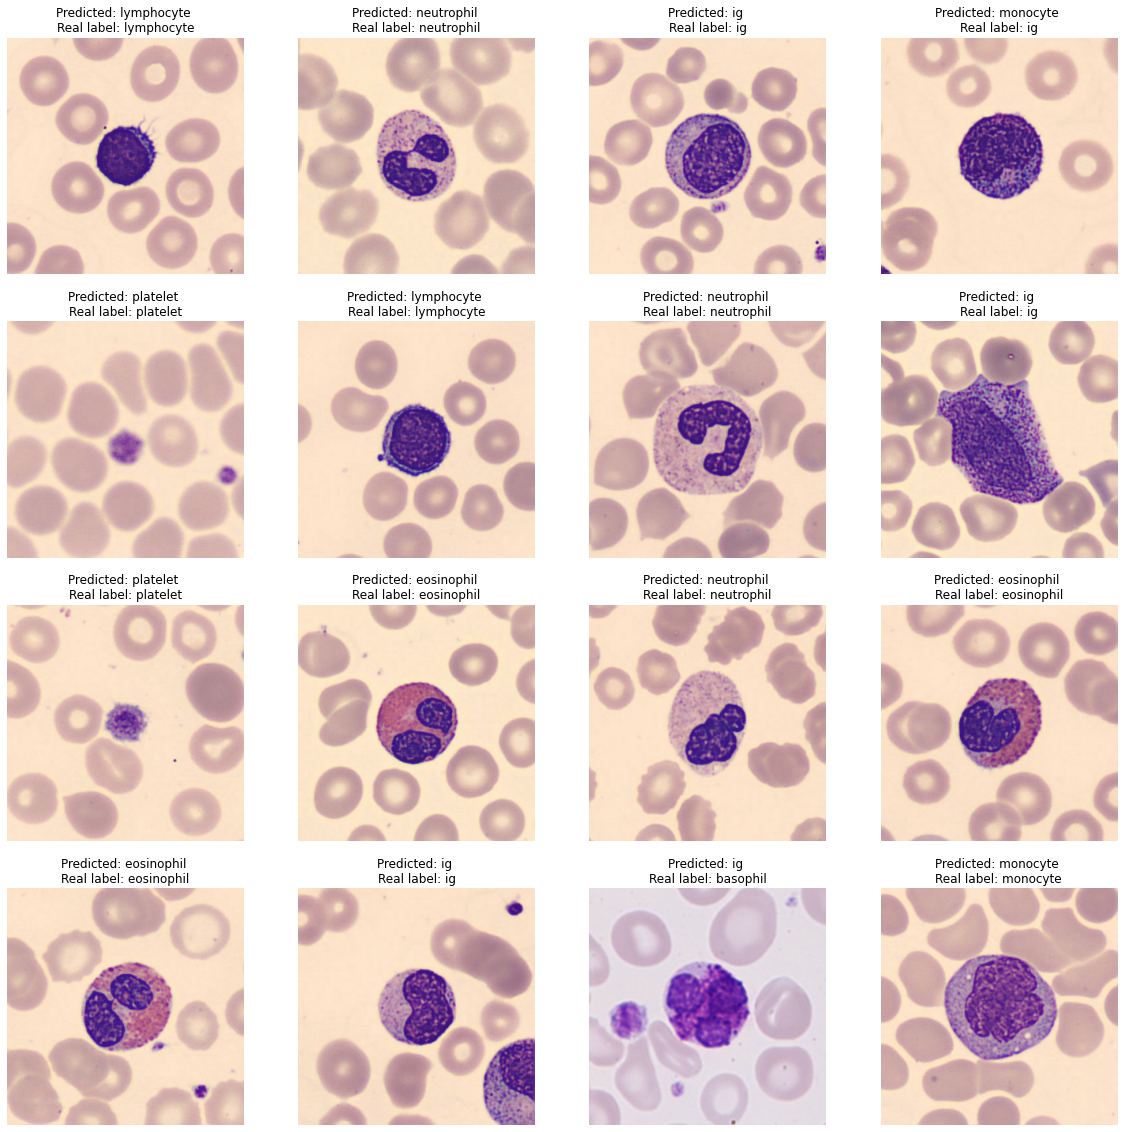

In [13]:
plt.figure(figsize=(20, 20))

# Generate predictions
predictions = model.predict(eval_images)
predicted_indexes = np.argmax(predictions, axis=1)
        

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)

    # Show image
    plt.imshow(eval_images[i].astype("uint8"))

    # Predicted class
    predicted_class = class_names[predicted_indexes[i]]

    # Real class
    real_class = class_names[eval_labels[i]]

    # Title 
    plt.title(f'Predicted: {predicted_class} \nReal label: {real_class}')

    plt.axis("off")

As you can see most of this batch is predicted correctly.

## References

1. **bloods cells type recognition with 80%> precision** by GABRIEL CARVALHO [Kaggle notebook](https://www.kaggle.com/code/gabrielcarvalho11/bloods-cells-type-recognition-with-80-precision)

2. **Blood Cells Image Dataset** by UNCLESAMULUS [Kaggle dataset](https://www.kaggle.com/datasets/unclesamulus/blood-cells-image-dataset)